# Analysis of large PBMC panel

In [27]:
import os
import scanpy as sc
import anndata as ann
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import datetime
import pytometry as pm


sc.logging.print_versions()
sc.settings.verbosity = 3 

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.8.0
scanpy      1.8.1
sinfo       0.3.4
-----
2f7ece400a652629565c523b34ee61b04afa385c    NA
PIL                                         8.4.0
absl                                        NA
anyio                                       NA
asciitree                                   NA
astunparse                                  1.6.3
attr                                        21.2.0
babel                                       2.9.1
backcall                                    0.2.0
beta_ufunc

In [2]:
sc.settings.figdir = './../figures/' 

Add date.

In [3]:
now = datetime.datetime.now()
today = now.strftime("%Y%m%d")

In [4]:
#Define a nice colour map for gene expression
colors2 = pl.cm.Reds(np.linspace(0, 1, 80))
colors3 = pl.cm.Greys_r(np.linspace(0.7,0.8,10))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

# Introduction

In this notebook, we annotate flow data of healthy human donors of the Knoll et al. (2023) study conducted at the DZNE Bonn (Germany) by the Anna Aschenbrenner group. 
We employ the following steps:
1. Load normalised data
2. Annotate clusters

# Read data

In [5]:
data_path = './../data/Convex_gating_test_MB/'

In [11]:
adata = sc.read(data_path + 'anndata/' + 'HIV_data_norm.h5ad')

In [12]:
adata

AnnData object with n_obs × n_vars = 1142610 × 27
    obs: 'sample', 'FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'Time', 'batch', 'louvain'
    var: 'channel', 'marker', 'signal_type', 'channel_tmp'
    uns: 'batch_colors', 'louvain', 'meta', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'compensated', 'original'
    obsp: 'connectivities', 'distances'

Check sample size.

In [8]:
adata.obs['sample'].value_counts()

NL05    377311
NL03    268668
NL01    260743
NL09    160884
NL07     75004
Name: sample, dtype: int64

# Plot data

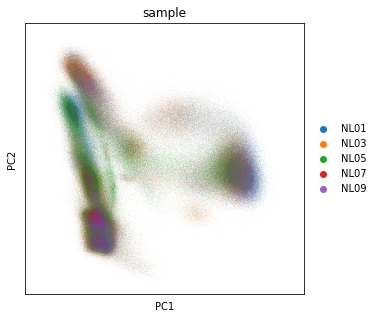

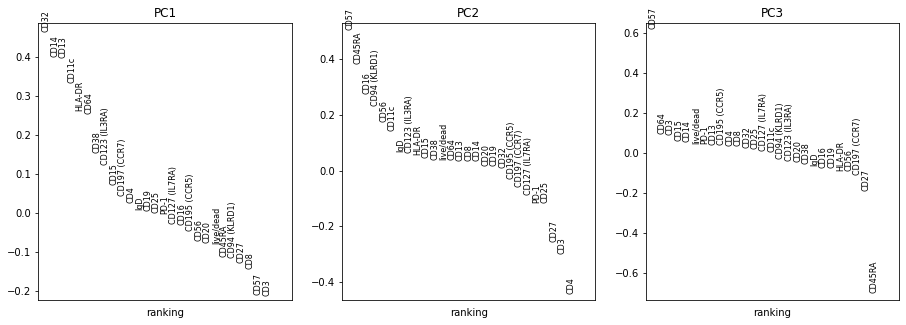

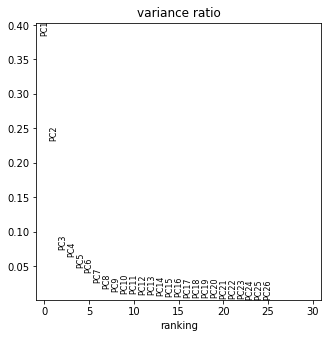

In [15]:
sc.pl.pca_overview(adata, color='sample')

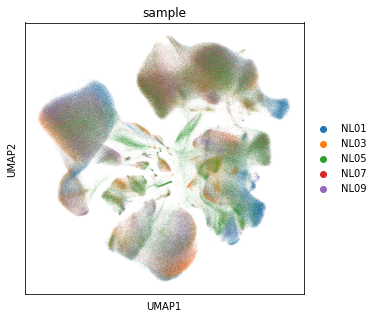

In [16]:
rcParams['figure.figsize']=(5,5)
sc.pl.umap(adata, color=['sample'])

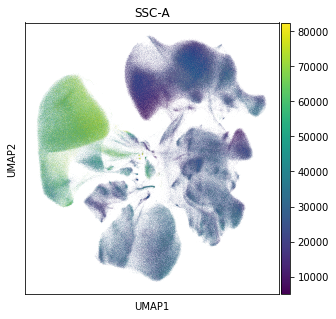

In [13]:
rcParams['figure.figsize']=(5,5)
sc.pl.umap(adata, color=[ 'SSC-A'], ncols=1, vmax='p99')

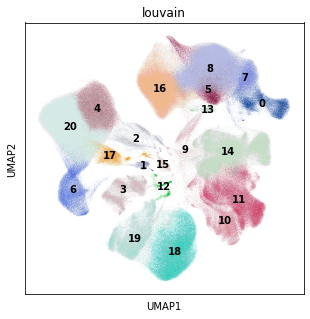

In [18]:
rcParams['figure.figsize']=(5,5)
sc.pl.umap(adata, color='louvain', legend_loc='on data')

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_louvain']`


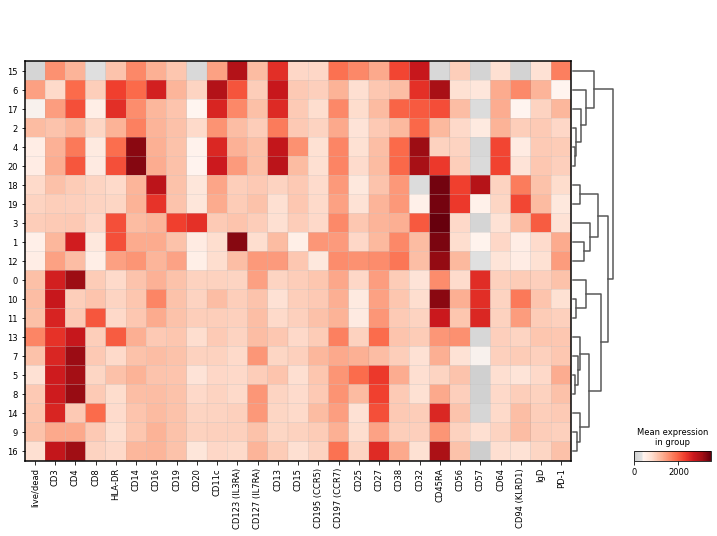

In [20]:
sc.pl.matrixplot(adata, groupby='louvain', 
                 var_names = ['live/dead', 'CD3','CD4', 'CD8', 'HLA-DR', 
                              'CD14', 'CD16', 'CD19', 'CD20', 
                              'CD11c', 'CD123 (IL3RA)', 'CD127 (IL7RA)', 'CD13',
                              'CD15', 'CD195 (CCR5)', 'CD197 (CCR7)','CD25',
                              'CD27', 'CD38', 'CD32','CD45RA', 'CD56', 'CD57',
                              'CD64', 'CD94 (KLRD1)', 'IgD', 'PD-1',
                             ], 
                 dendrogram = True, vmin=0, 
                 cmap=mymap)

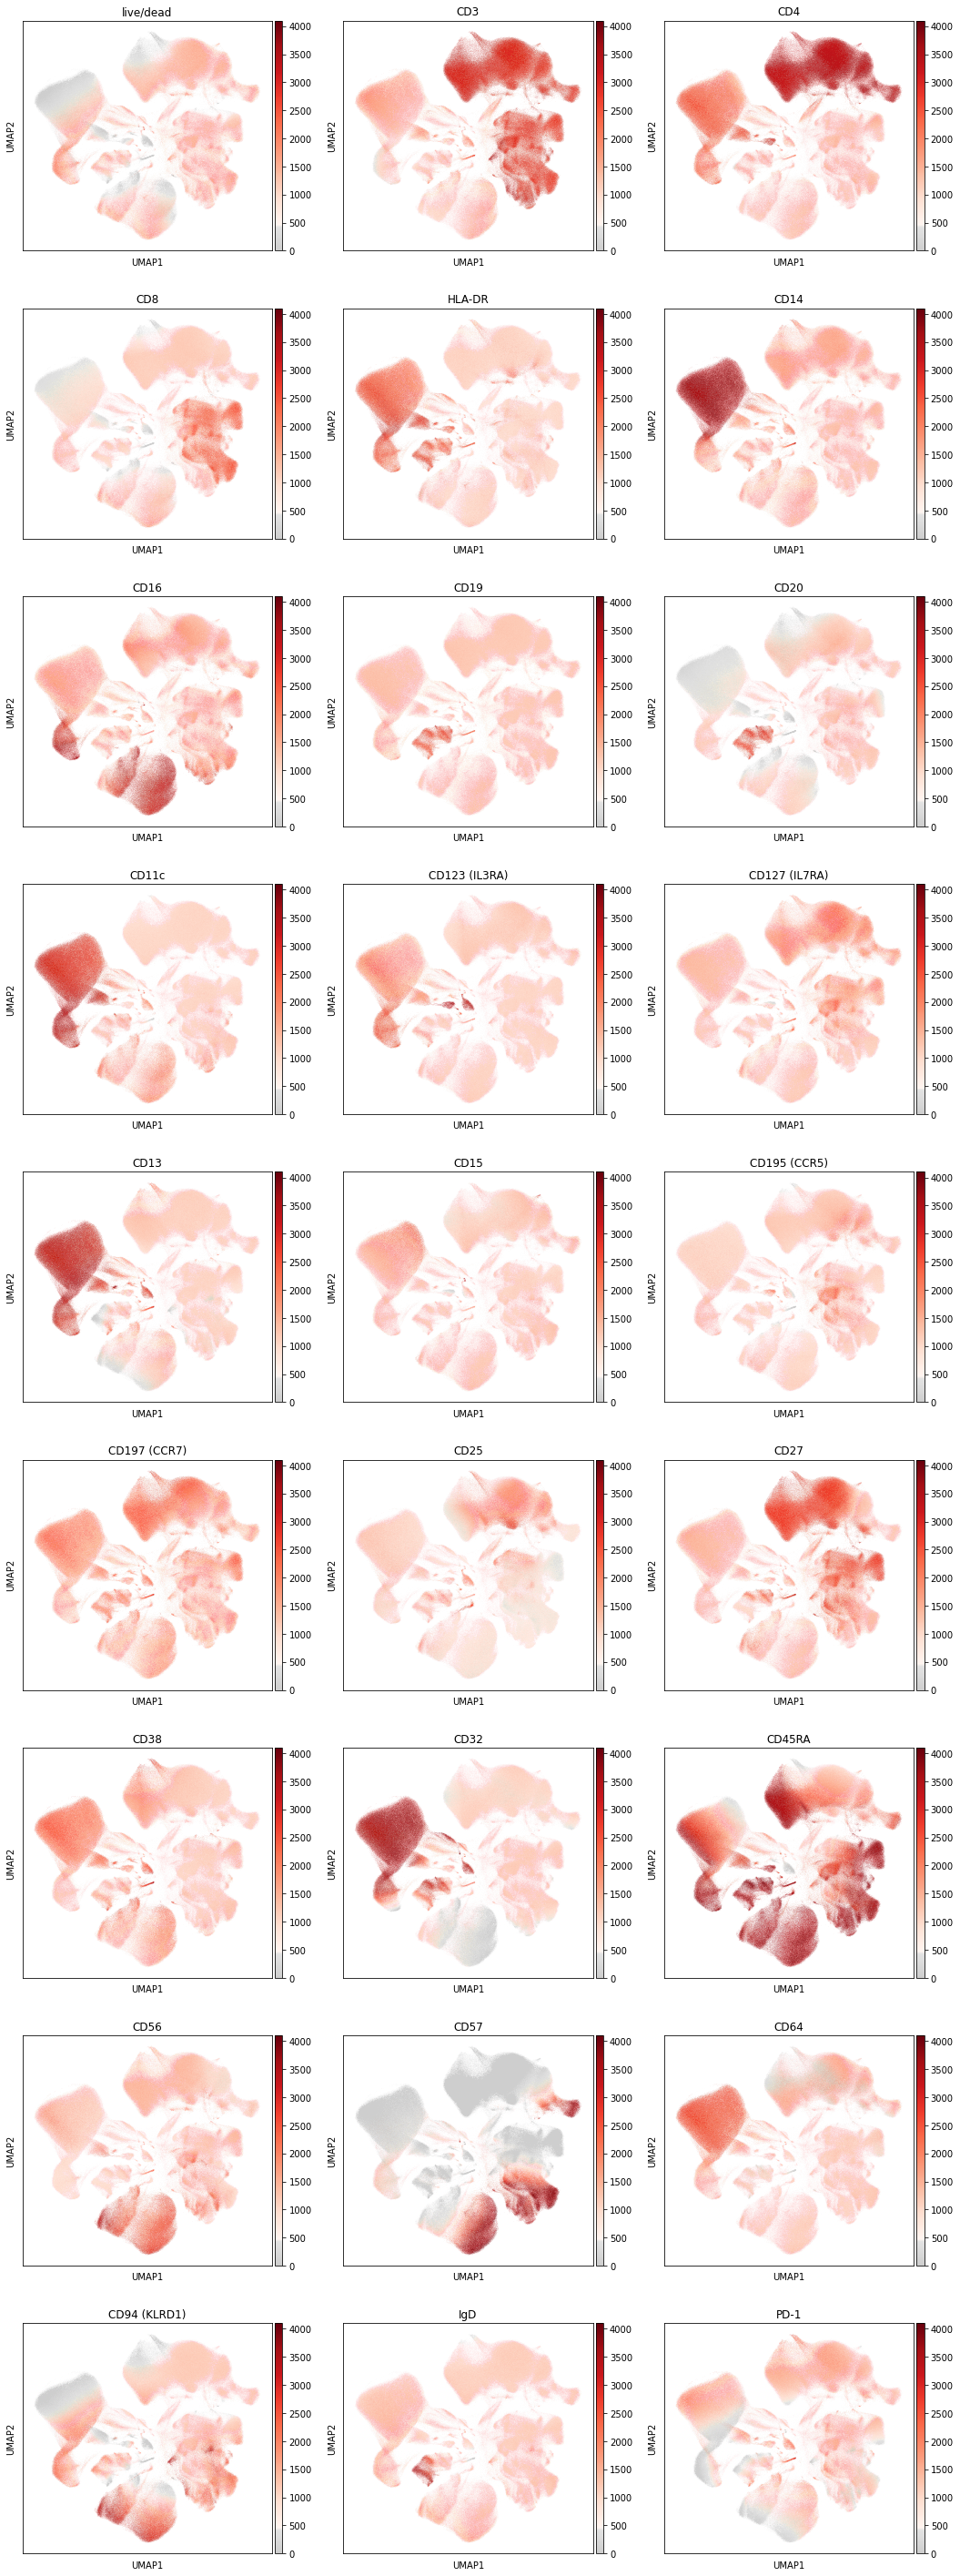

In [21]:
rcParams['figure.figsize']=(5,5)
sc.pl.umap(adata, color=['live/dead', 'CD3','CD4', 'CD8', 'HLA-DR', 
                              'CD14', 'CD16', 'CD19', 'CD20', 
                              'CD11c', 'CD123 (IL3RA)', 'CD127 (IL7RA)', 'CD13',
                              'CD15', 'CD195 (CCR5)', 'CD197 (CCR7)','CD25',
                              'CD27', 'CD38', 'CD32','CD45RA', 'CD56', 'CD57',
                              'CD64', 'CD94 (KLRD1)', 'IgD', 'PD-1',
                             ], ncols=3, cmap=mymap, vmax=4100, vmin=0)

# Annotate clusters

In the next step, we annotate the following populations on this data set:

* B cells (CD19 positive) 
* NK cells (CD56 positive)
* T cells (CD3 positive) with the subpopulations 
    * CD4+ T cells 
    * CD8+ T cells 
    * NKT cells (CD56 and CD3 positive)
* Monocytes with the subpopulations 
    * classical 
    * intermediate
    * non-classical monocytes
* Dendritic cells with the subpopulations 
    * cDCs (CD11c positive, CD45RA positive)
    * pDCs (CD123 positive, CD11c negative, CD45RA positive)



In [6]:
adata = sc.read(os.path.join(data_path, 'anndata', 'HIV_data_annotated.h5ad'))

In [7]:
mapping = {
    '0' : 'T cell',
    '1' : 'Dendritic cell', #plasmacytoid DC/pre-DC
    '2' : 'not annotated',
    '3' : 'B cell',
    '4' : 'Monocyte',
    '5' : 'T cell',
    '6' : 'Monocyte',
    '7' : 'T cell',
    '8' : 'T cell',
    '9' : 'T cell',
    '10' : 'T cell',
    '11' : 'T cell',
    '12' : 'B cell',
    '13' : 'T cell',
    '14' : 'T cell',
    '15' : 'Dendritic cell', #pre-DC
    '16' : 'T cell',
    '17' : 'Dendritic cell',
    '18' : 'NK cell',
    '19' : 'NK cell',
    '20' : 'Monocyte',
}


In [8]:
adata.obs['cluster cell_type_lvl_1'] = adata.obs['louvain'].map(mapping).copy()

... storing 'cluster cell_type_lvl_1' as categorical


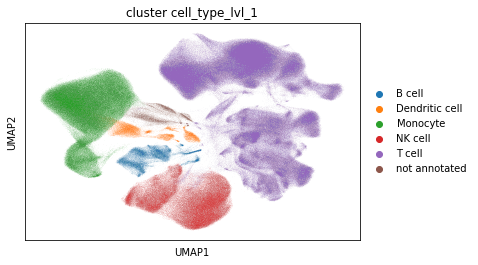

In [9]:
sc.pl.umap(adata, color='cluster cell_type_lvl_1')

Let us zoom into the T cell population and distinguish CD4+, CD8+ and NKT cells.

In [10]:
mapping_lvl2 = {
    '0' : 'CD4+ T cell',
    '1' : 'Dendritic cell',
    '2' : 'not annotated',
    '3' : 'B cell',
    '4' : 'Monocyte',
    '5' : 'CD4+ T cell',
    '6' : 'Monocyte',
    '7' : 'CD4+ T cell',
    '8' : 'CD4+ T cell',
    '9' : 'T cell',
    '10' : 'T cell',
    '11' : 'CD8+ T cell',
    '12' : 'B cell',
    '13' : 'NK T cell',
    '14' : 'CD8+ T cell',
    '15' : 'Dendritic cell',
    '16' : 'CD4+ T cell',
    '17' : 'Dendritic cell',
    '18' : 'NK cell',
    '19' : 'NK cell',
    '20' : 'Monocyte',
}


In [11]:
adata.obs['cluster cell_type_lvl_2'] = adata.obs['louvain'].map(mapping_lvl2).copy()

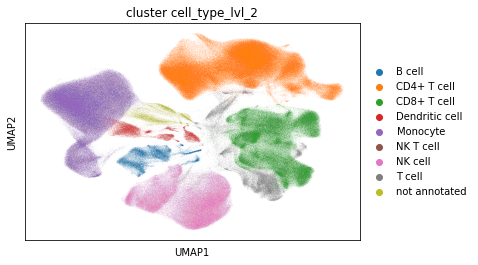

In [14]:
sc.pl.umap(adata, color='cluster cell_type_lvl_2')

## Characterise monocyte subsets

In order to annotate monocytes, we subset the annotated dataframe to the monocyte subsets.

In [19]:
adata_mono = adata[adata.obs['cluster cell_type_lvl_2']=='Monocyte'].copy()

Recompute embedding.

In [16]:
sc.pp.pca(adata_mono)
sc.pp.neighbors(adata_mono)
sc.tl.umap(adata_mono)

computing PCA
    with n_comps=26
    finished (0:00:02)
computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:25)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:05:59)


In [17]:
sc.tl.louvain(adata_mono, flavor='rapids') 

running Louvain clustering
    using the "louvain" package of rapids
    finished: found 22 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:29)


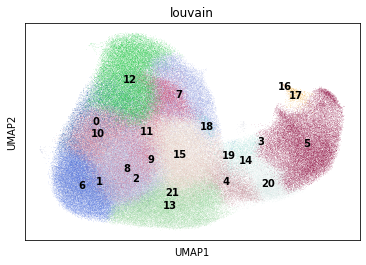

In [18]:
sc.pl.umap(adata_mono, color='louvain', legend_loc='on data')

In [21]:
if 'dendrogram_louvain' in adata_mono.uns_keys():
    del adata_mono.uns['dendrogram_louvain']

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_louvain']`


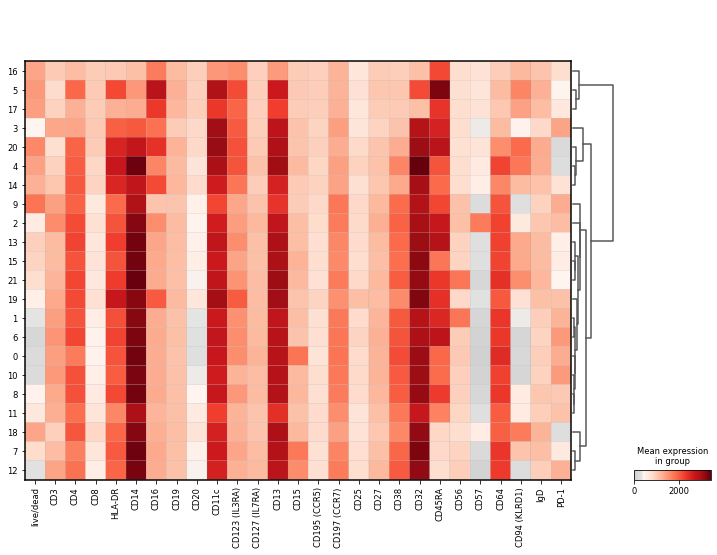

In [20]:
sc.pl.matrixplot(adata_mono, groupby='louvain', 
                 var_names = ['live/dead', 'CD3','CD4', 'CD8', 'HLA-DR', 
                              'CD14', 'CD16', 'CD19', 'CD20', 
                              'CD11c', 'CD123 (IL3RA)', 'CD127 (IL7RA)', 'CD13',
                              'CD15', 'CD195 (CCR5)', 'CD197 (CCR7)','CD25',
                              'CD27', 'CD38', 'CD32','CD45RA', 'CD56', 'CD57',
                              'CD64', 'CD94 (KLRD1)', 'IgD', 'PD-1',
                             ], 
                 dendrogram = True, vmin=0, 
                 cmap=mymap)

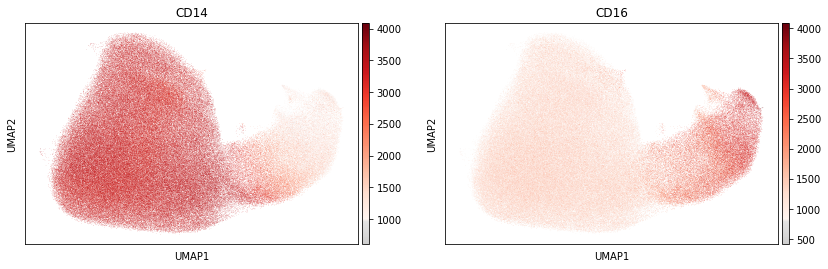

In [22]:
sc.pl.umap(adata_mono, color=['CD14','CD16'], cmap=mymap)

In [33]:
mapping_mono = {
    '0' : 'Classical monocyte',
    '1' : 'Classical monocyte',
    '2' : 'Classical monocyte',
    '3' : 'Intermediate monocyte', #
    '4' : 'Intermediate monocyte', #
    '5' : 'Non-classical monocyte', #
    '6' : 'Classical monocyte',
    '7' : 'Classical monocyte',
    '8' : 'Classical monocyte',
    '9' : 'Classical monocyte',
    '10' : 'Classical monocyte',
    '11' : 'Classical monocyte',
    '12' : 'Classical monocyte',
    '13' : 'Classical monocyte',
    '14' : 'Intermediate monocyte',#
    '15' : 'Classical monocyte',
    '16' : 'Non-classical monocyte', #
    '17' : 'Non-classical monocyte', #
    '18' : 'Classical monocyte',
    '19' : 'Intermediate monocyte',#
    '20' : 'Intermediate monocyte',#
    '21' : 'Classical monocyte'
}


In [34]:
adata_mono.obs['cell_type_lvl_2'] = adata_mono.obs['louvain'].map(mapping_mono).copy()

In [35]:
adata_mono.obs['cell_type_lvl_2'] = adata_mono.obs['cell_type_lvl_2'].astype('category')

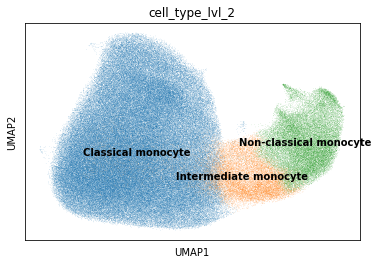

In [36]:
sc.pl.umap(adata_mono, color='cell_type_lvl_2', legend_loc='on data')

Add annotation to full dataset.

In [39]:
adata.obs['cluster cell_type_lvl_2'] = adata.obs['cluster cell_type_lvl_2'].astype('category')

In [41]:
adata.obs['cluster cell_type_lvl_2'] = adata.obs['cluster cell_type_lvl_2'].cat.add_categories(['Classical monocyte', 
                                                                            'Non-classical monocyte', 
                                                                            'Intermediate monocyte'
                                                                            ])
adata_mono.obs['cluster cell_type_lvl_2'] = adata_mono.obs[cluster 'cell_type_lvl_2'].cat.add_categories(
    np.setdiff1d(adata.obs['cluster cell_type_lvl_2'].cat.categories, 
                 adata_mono.obs['cell_type_lvl_2'].cat.categories))
adata.obs['cluster cell_type_lvl_2'][adata.obs['cluster cell_type_lvl_2'].isin(['Monocyte'])] = adata_mono.obs['cell_type_lvl_2']

adata.obs['cluster cell_type_lvl_2'] = adata.obs['cluster cell_type_lvl_2'].cat.remove_unused_categories()

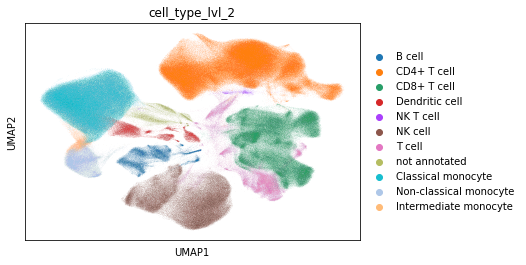

In [42]:
sc.pl.umap(adata, color='cluster cell_type_lvl_2')

## Characterise dendritic cell subsets

In order to annotate dendritic cells, we subset the annotated dataframe to the dendritic cell subsets.

In [12]:
adata_dc = adata[adata.obs['cluster cell_type_lvl_2']=='Dendritic cell'].copy()

In [13]:
adata_dc

AnnData object with n_obs × n_vars = 24443 × 27
    obs: 'sample', 'FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'Time', 'gate_root', 'gate_PBMC', 'gate_Single Cells', 'gate_Living', 'gate_B cells', 'gate_B cells (no class switch)', 'gate_B cells (switched memory)', 'gate_Living--others', 'gate_NK cells', 'gate_CD16high NK', 'gate_NK Immature', 'gate_NK Mature', 'gate_CD16low NK', 'gate_Living--others--others', 'gate_CD16 Monos', 'gate_Conv. Monos', 'gate_Int. Monos', 'gate_others--others--others', 'gate_cDCs', 'gate_pDCs', 'gate_Pre-DCs', 'gate_Living--T cells', 'gate_NKT', 'gate_CD4+NKT', 'gate_CD8+NKT', 'gate_otherNKT', 'gate_T cells--T cells', 'gate_CD4+ T cells', 'gate_CM CD4', 'gate_Eff. CD4', 'gate_Naive CD4', 'gate_PD1+ CD4 T cells', 'gate_TD CD4', 'gate_CD8+T cells', 'gate_CM CD8', 'gate_Eff. CD8', 'gate_Naive CD8', 'gate_TD CD8', 'batch', 'louvain', 'cell_type_lvl_1', 'cell_type_lvl_2', 'cluster cell_type_lvl_1', 'cluster cell_type_lvl_2'
    var: 'channel', 'marker',

Recompute embedding.

In [14]:
sc.pp.pca(adata_dc)
sc.pp.neighbors(adata_dc)
sc.tl.umap(adata_dc)

computing PCA
    with n_comps=26
    finished (0:00:00)
computing neighbors
    using data matrix X directly


2025-02-12 07:30:13.279639: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/R/lib/R/lib::/.singularity.d/libs
2025-02-12 07:30:13.279736: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:45)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:19)


In [28]:
sc.tl.louvain(adata_dc, resolution=1.2) 

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 15 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:03)


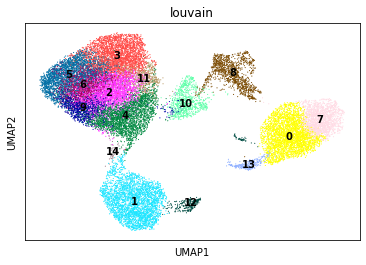

In [29]:
sc.pl.umap(adata_dc, color='louvain', legend_loc='on data')

In [31]:
if 'dendrogram_louvain' in adata_dc.uns_keys():
    del adata_dc.uns['dendrogram_louvain']

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_louvain']`


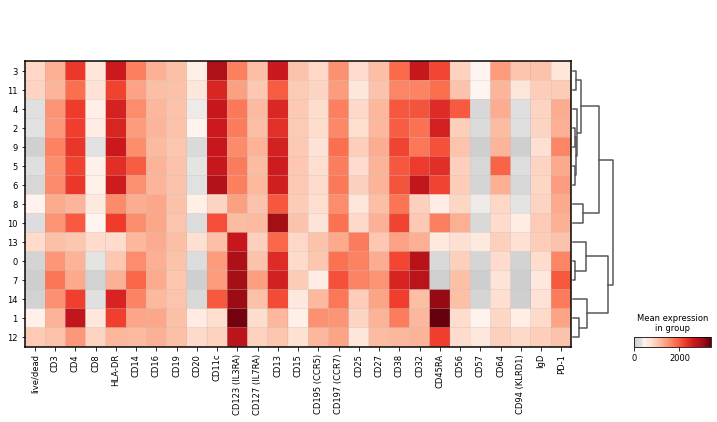

In [32]:
sc.pl.matrixplot(adata_dc, groupby='louvain', 
                 var_names = ['live/dead', 'CD3','CD4', 'CD8', 'HLA-DR', 
                              'CD14', 'CD16', 'CD19', 'CD20', 
                              'CD11c', 'CD123 (IL3RA)', 'CD127 (IL7RA)', 'CD13',
                              'CD15', 'CD195 (CCR5)', 'CD197 (CCR7)','CD25',
                              'CD27', 'CD38', 'CD32','CD45RA', 'CD56', 'CD57',
                              'CD64', 'CD94 (KLRD1)', 'IgD', 'PD-1',
                             ], 
                 dendrogram = True, vmin=0, 
                 cmap=mymap)

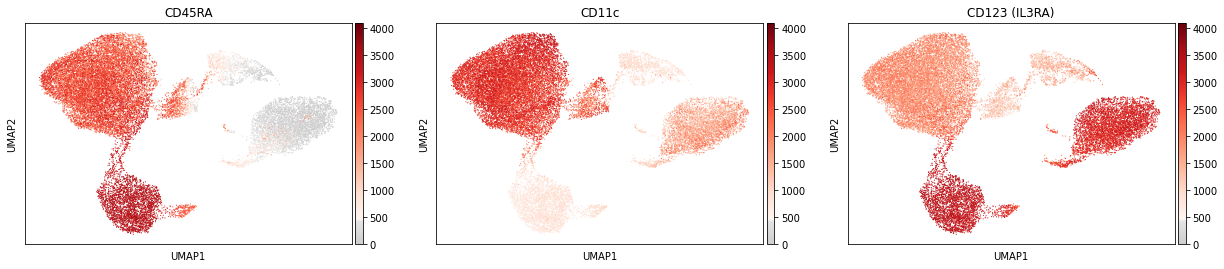

In [48]:
sc.pl.umap(adata_dc, color=['CD45RA', 'CD11c', 'CD123 (IL3RA)'], 
           cmap=mymap, vmax=4100)

Dendritic cells with the subpopulations (CD45RA positive):
* cDCs (CD11c positive)
* pDCs (CD123 positive, CD11c negative)

In [33]:
mapping_dc = {
    '0' : 'not annotated', #
    '1' : 'pDC', # 
    '2' : 'cDC', #
    '3' : 'cDC', #
    '4' : 'cDC', #
    '5' : 'cDC', #
    '6' : 'cDC', #
    '7' : 'not annotated', #
    '8' : 'not annotated', #
    '9' : 'cDC',  #
    '10' : 'cDC', #
    '11' : 'cDC', #
    '12' : 'pDC', #
    '13' : 'not annotated', #
    '14' : 'cDC', #
     
   
}


In [34]:
adata_dc.obs['cell_type_lvl_2'] = adata_dc.obs['louvain'].map(mapping_dc).copy()

In [35]:
adata_dc.obs['cell_type_lvl_2'] = adata_dc.obs['cell_type_lvl_2'].astype('category')

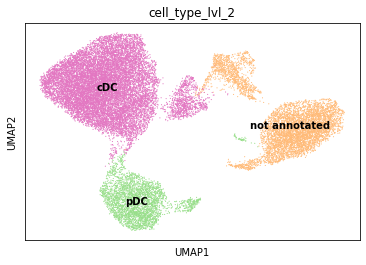

In [36]:
sc.pl.umap(adata_dc, color='cell_type_lvl_2', legend_loc='on data')

Add annotation to full dataset.

In [46]:
#adata.obs['cluster cell_type_lvl_2'] = adata.obs['cluster cell_type_lvl_2'].cat.add_categories(['cDC','pDC'])
adata_dc.obs['cell_type_lvl_2'] = adata_dc.obs['cell_type_lvl_2'].cat.add_categories(
    np.setdiff1d(adata.obs['cluster cell_type_lvl_2'].cat.categories, 
                 adata_dc.obs['cell_type_lvl_2'].cat.categories))
adata.obs['cluster cell_type_lvl_2'] = adata.obs['cluster cell_type_lvl_2'].cat.add_categories(
    np.setdiff1d( 
                 adata_dc.obs['cell_type_lvl_2'].cat.categories, adata.obs['cluster cell_type_lvl_2'].cat.categories))
adata.obs['cluster cell_type_lvl_2'][adata.obs['cluster cell_type_lvl_2'].isin(['Dendritic cell'])] = adata_dc.obs['cell_type_lvl_2']

adata.obs['cluster cell_type_lvl_2'] = adata.obs['cluster cell_type_lvl_2'].cat.remove_unused_categories()

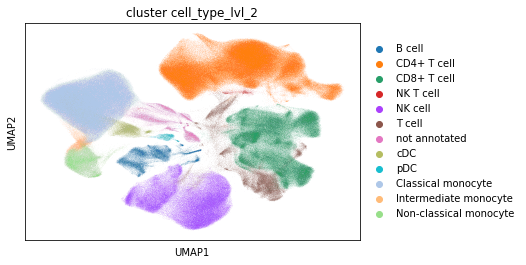

In [68]:
sc.pl.umap(adata, color='cluster cell_type_lvl_2')

Clean up `cluster cell type lvl 1` as we have re-annotated some subpopulations as `not annotated` in the DC population.

In [69]:
adata.obs['cluster cell_type_lvl_1'][adata.obs['cluster cell_type_lvl_2'].isin(['not annotated'])] = 'not annotated' 

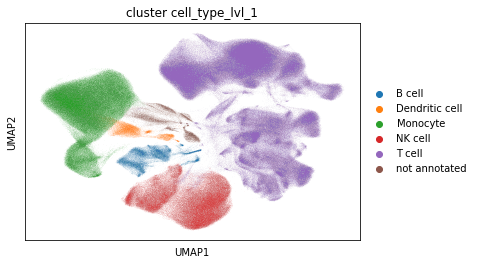

In [70]:
sc.pl.umap(adata, color='cluster cell_type_lvl_1')

Get proportions.

In [71]:
pd.crosstab(adata.obs['cluster cell_type_lvl_1'], adata.obs['sample'], normalize=1, margins=True)

sample                       NL01      NL03      NL05      NL07      NL09  \
cluster cell_type_lvl_1                                                     
B cell                   0.017370  0.042372  0.049543  0.020039  0.008335   
Dendritic cell           0.012322  0.014382  0.014569  0.014933  0.028586   
Monocyte                 0.311119  0.212161  0.173687  0.188750  0.320653   
NK cell                  0.107094  0.137828  0.104428  0.202443  0.166331   
T cell                   0.542906  0.570358  0.628073  0.564810  0.467716   
not annotated            0.009189  0.022898  0.029700  0.009026  0.008379   

sample                        All  
cluster cell_type_lvl_1            
B cell                   0.032776  
Dendritic cell           0.016010  
Monocyte                 0.235778  
NK cell                  0.128040  
T cell                   0.568336  
not annotated            0.019061

In [72]:
pd.crosstab(adata.obs['cluster cell_type_lvl_2'], adata.obs['sample'], normalize=1, margins=True)

sample                       NL01      NL03      NL05      NL07      NL09  \
cluster cell_type_lvl_2                                                     
B cell                   0.017370  0.042372  0.049543  0.020039  0.008335   
CD4+ T cell              0.232133  0.384463  0.339251  0.430030  0.341090   
CD8+ T cell              0.249652  0.163361  0.204073  0.129126  0.097660   
NK T cell                0.000380  0.004407  0.003432  0.001187  0.000721   
NK cell                  0.107094  0.137828  0.104428  0.202443  0.166331   
T cell                   0.060742  0.018126  0.081318  0.004466  0.028244   
not annotated            0.009189  0.022898  0.029700  0.009026  0.008379   
cDC                      0.010880  0.010697  0.010652  0.012186  0.026765   
pDC                      0.001442  0.003685  0.003917  0.002747  0.001821   
Classical monocyte       0.267378  0.167299  0.148485  0.170778  0.252530   
Intermediate monocyte    0.022827  0.011122  0.005327  0.005186  0.012723   
Non-classical monocyte   0.020913  0.033741  0.019875  0.012786  0.055400   

sample                        All  
cluster cell_type_lvl_2            
B cell                   0.032776  
CD4+ T cell              0.331656  
CD8+ T cell              0.184998  
NK T cell                0.002436  
NK cell                  0.128040  
T cell                   0.049246  
not annotated            0.019061  
cDC                      0.013084  
pDC                      0.002926  
Classical monocyte       0.196154  
Intermediate monocyte    0.011715  
Non-classical monocyte   0.027909

## Save to file

In [77]:
adata.write(data_path + 'anndata/' + 'HIV_data_annotated_final.h5ad')